In [31]:
import os
import re
import json
from typing import Optional
import numpy as np
import pytorch_lightning as pl
import cv2
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
from albumentations import Compose, Resize, Normalize

PATH_DATA = "/home/ubuntu/datasets/segment_car_plate/data/"

In [32]:
with open(os.path.join(PATH_DATA, "train_recognition.json")) as fp:
    obj = json.load(fp)
fname2text = {os.path.basename(rec["file"]):rec["text"] for rec in obj}

assert len(obj) == len(fname2text)

In [33]:
config = []

for idx, fname in enumerate(
    os.listdir(os.path.join(PATH_DATA,"train"))
):
    if re.fullmatch(
        pattern=r"\d+\.box\.\d+\.jpg",
        string=fname
    ):
        config.append(
            (fname, fname2text[fname])
        )


In [34]:
class RecDataset(Dataset):
    def __init__(self, data_dir, config, abc, split, transforms=None):
        super(RecDataset, self).__init__()
        self.data_dir = data_dir
        self.abc = abc
        self.transforms = transforms
        self.split = split
        self.config = config

    def __len__(self):
        return len(self.images)

    def text_to_seq(self, text):
        seq = [self.abc.find(c) + 1 for c in text]
        return seq
    
    def __getitem__(self, idx):
        fname, text = self.config[idx]
        fpath = os.path.join(self.data_dir, fname)
        image = cv2.imread(fpath).astype(np.float32) / 255.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        seq = self.text_to_seq(text)
        seq_len = len(seq)
        item = dict(image=image, seq=seq, seq_len=seq_len, text=text)
        if self.transforms is not None:
            item = self.transforms(item)    
        return item

    @staticmethod
    def collate_fn(batch):
        images = list()
        seqs = list()
        seq_lens = list()
        for sample in batch:
            images.append(torch.from_numpy(sample["image"].transpose((2, 0, 1))).float())
            seqs.extend(sample["seq"])
            seq_lens.append(sample["seq_len"])
        images = torch.stack(images)
        seqs = torch.Tensor(seqs).int()
        seq_lens = torch.Tensor(seq_lens).int()
        batch = {"images": images, "seqs": seqs, "seq_lens": seq_lens}
        return batch


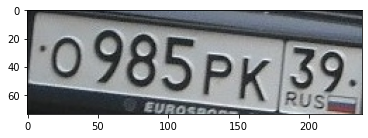

In [36]:
abc = "0123456789ABCEHKMOPTXY"
mapping = {
    'А': 'A',
    'В': 'B',
    'С': 'C',
    'Е': 'E',
    'Н': 'H',
    'К': 'K',
    'М': 'M',
    'О': 'O',
    'Р': 'P',
    'Т': 'T',
    'Х': 'X',
    'У': 'Y',
}
ds = RecDataset(
    data_dir=os.path.join(PATH_DATA,"train"), config=config, abc=abc, split="train"
)
item = ds[1]
plt.imshow(item["image"])